In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.misc # to visualize only
import cv2
import matplotlib.image as mpimg
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import time

In [4]:
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [5]:
X_test = pd.read_csv('Datasets/test_x.csv', sep=',', header=None).as_matrix()
X_test = X_test .reshape(-1,64,64)

In [6]:
y_train = pd.read_csv('Datasets/train_y.csv', sep=',', header=None).as_matrix()
y_train = np.ravel(y_train)

In [7]:
X_train = pd.read_csv('Datasets/train_x.csv', sep=',', header=None).as_matrix()
X_train = X_train .reshape(-1,64,64)

In [8]:
print ("X_train shape:", X_train.shape)
print ("y_train shape:", y_train.shape)
print ("X_test  shape:", X_test.shape)

('X_train shape:', (50000, 64, 64))
('y_train shape:', (50000,))
('X_test  shape:', (10000, 64, 64))


# To visualize an image

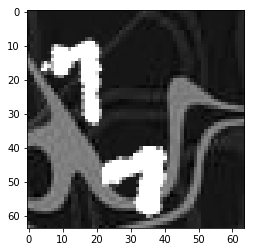

In [13]:
X_train = X_train.reshape(-1,64,64)
imgplot = plt.imshow(X_train[1],'gray')
plt.show()

# Pre-Processing

In [9]:
def binary_tresholding(image):
    for i in range(len(image)):
        for j in range(len(image)):
            if image[i, j] < 254:
                image[i, j] = 0
    return image

In [10]:
#Binarize all train images
images_train = np.zeros(X_train.shape)
for i in range(X_train.shape[0]):
    images_train[i] = binary_tresholding(X_train[i])
    
#Binarize all test images
images_test = np.zeros(X_test.shape)
for i in range(X_test.shape[0]):
    images_test[i] = binary_tresholding(X_test[i])

In [11]:
print (X_train.shape)
print (X_test.shape)

(50000, 64, 64)
(10000, 64, 64)


In [12]:
def find_the_largest_digit_center(image):
    thresh = binary_tresholding(image)
    thresh = thresh.astype('uint8')
    #plt.subplot(151)
    #plt.imshow(thresh,'gray')
    #plt.title('Original')

    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    Ws = [] 
    Hs = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        Ws.append(w)
        Hs.append(h)
    max_h = max(Hs)
    max_w = max(Ws)
    max_l = max(max_h,max_w)

    # Find the index of the contour with largest width
    if max_l == max_h:
        max_index = np.argmax(Hs)
    else:
        max_index = np.argmax(Ws)
    x,y,w,h = cv2.boundingRect(contours[max_index])

    #to create a filter to remove all other digits and keep just the biggest one
    filter_ = np.zeros(image.shape)
    filter_ = cv2.rectangle(filter_,(x,y),(x+max_l,y+max_l),(255,255,255),-1)
    
    #find center of the component
    px = x+max_l/2
    py = y+max_l/2
    
    #plt.subplot(152)
    #plt.imshow(filter_,'gray')
    #plt.title('Filter')

    preprocessed_img = np.zeros(X_train[0].shape)
    preprocessed_img = thresh*filter_

    #plt.subplot(153)
    #plt.imshow(preprocessed_img,'gray')
    #plt.title('Largest Digit')

    # To shift the largest component to the center of an image
    preprocessed_img = preprocessed_img.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(preprocessed_img, connectivity=4)
    sizes = stats[:, -1]
    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]
        
    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255.
    
     # To shift the largest component to the center of an image
    px = 32 - centroids[max_label][0]
    py = 32 - centroids[max_label][1]
    M = np.float32([[1,0,px],[0,1,py]])
    dst = cv2.warpAffine(img2,M,(64,64))
    
    #plt.subplot(175)
    #plt.imshow(dst,'gray')
    #plt.title('Centered')
    
    dst = dst[18:46,18:46]
    #plt.subplot(176)
    #plt.imshow(dst,'gray')
    #plt.title('(28,28)')
    #plt.show()
    
    
    # deskew
    SZ = dst.shape[0]
    m = cv2.moments(dst)
    if abs(m['mu02']) < 1e-2:
        # no deskewing needed. 
        return dst.copy()
    # Calculate skew based on central momemts. 
    skew = m['mu11']/m['mu02']
    # Calculate affine transform to correct skewness. 
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    # Apply affine transform
    dst = cv2.warpAffine(dst, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR) # flags=affine_flags)
    
    #plt.subplot(177)
    #plt.imshow(dst,'gray')
    #plt.title('Deskewed')
    #plt.show()
    
    return dst

In [13]:
# find the biggest component in all dataset and shift it to center
prepTrainX = np.zeros([50000, 784])
for i in range(len(X_train)):
    img1 = find_the_largest_digit_center(images_train[i, :])
    img1 = img1.reshape((1, 784))
    prepTrainX[i, :] = img1
    
prepTestX = np.zeros([10000, 784])
for i in range(len(X_test)):
    img2 = find_the_largest_digit_center(images_test[i, :])
    img2 = img2.reshape((1, 784))
    prepTestX[i, :] = img2

In [14]:
print (y_train[0:50])

[4 7 1 0 8 7 7 8 0 7 4 0 9 0 4 8 8 8 9 1 9 7 9 8 3 8 8 3 8 3 6 8 3 8 6 1 0
 6 5 7 3 6 2 7 7 9 4 9 7 3]


# Visualization 

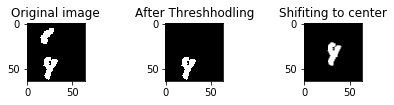

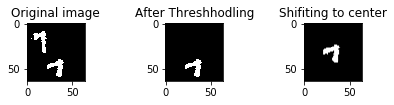

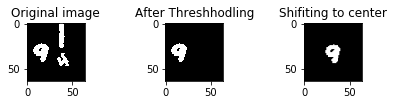

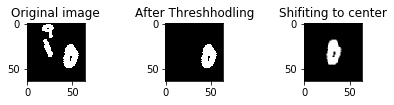

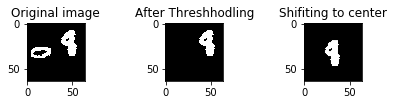

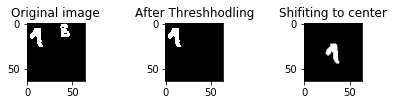

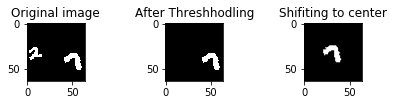

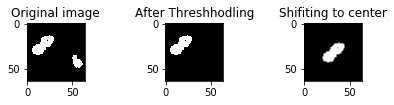

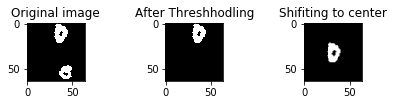

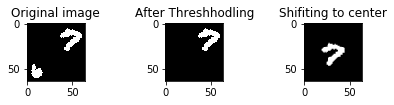

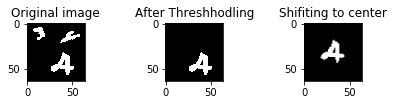

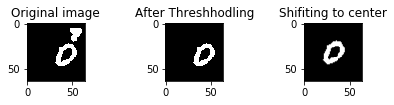

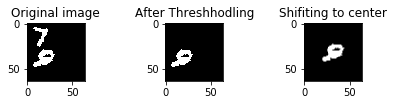

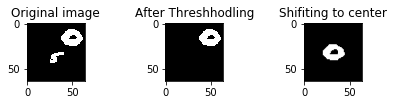

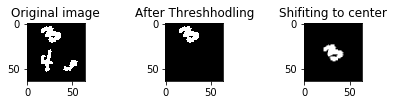

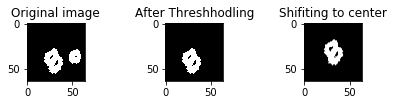

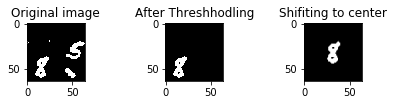

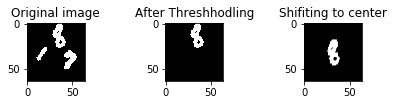

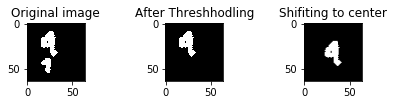

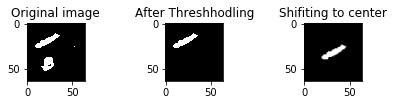

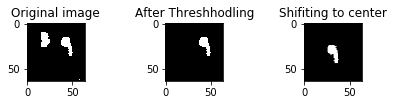

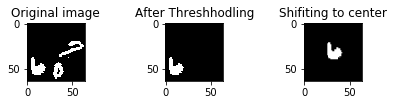

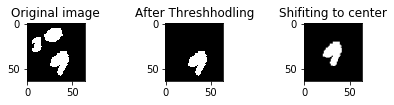

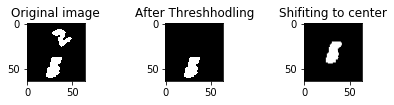

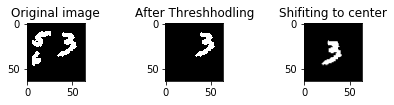

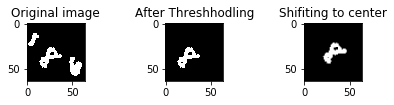

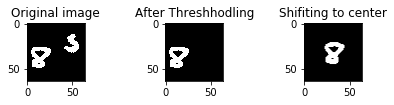

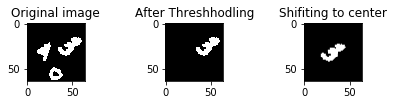

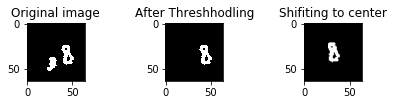

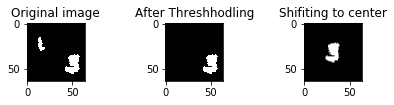

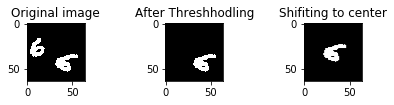

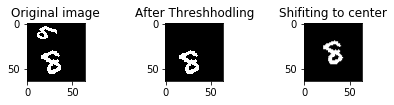

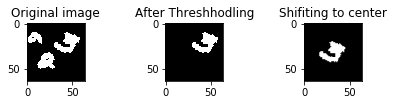

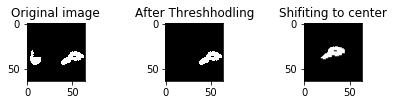

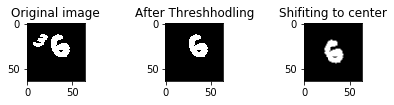

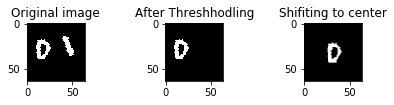

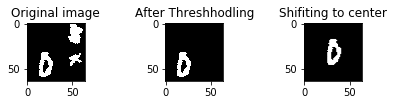

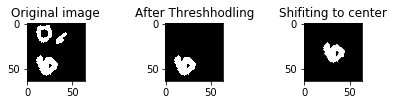

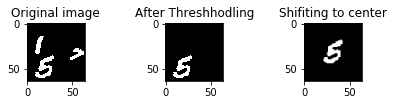

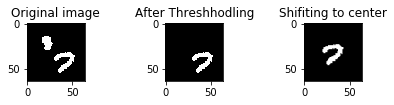

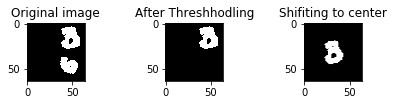

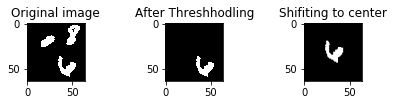

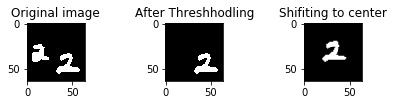

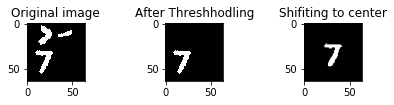

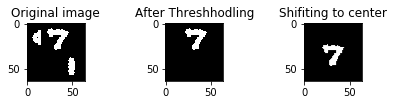

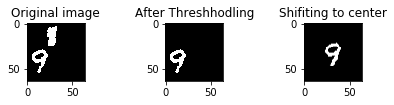

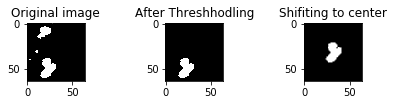

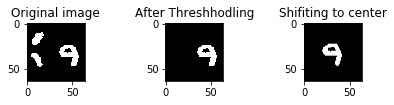

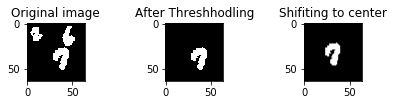

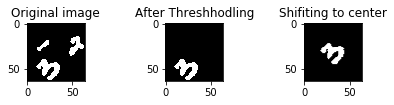

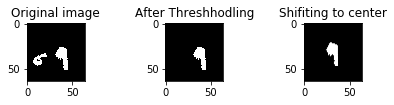

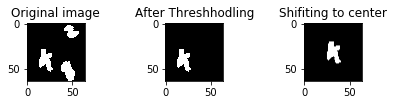

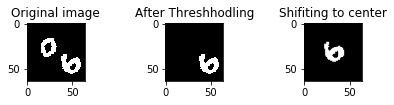

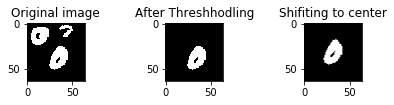

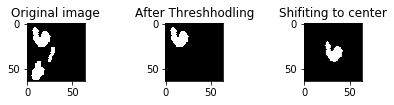

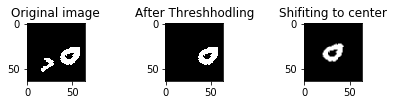

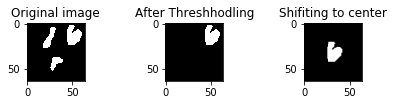

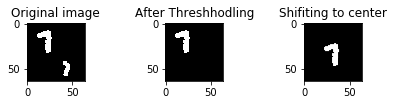

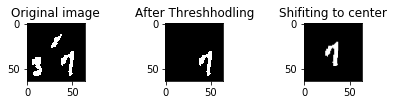

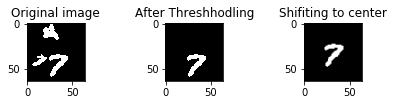

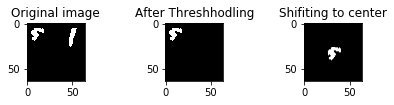

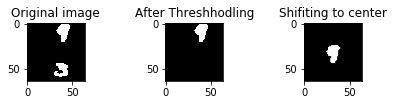

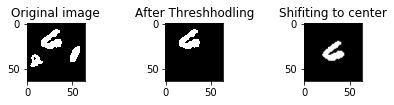

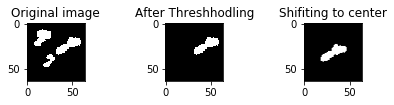

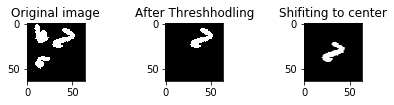

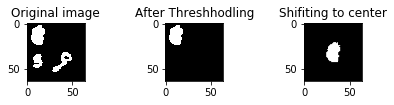

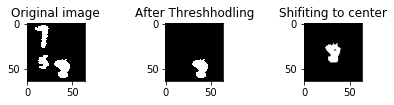

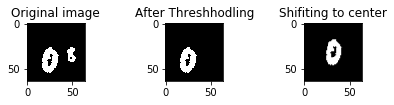

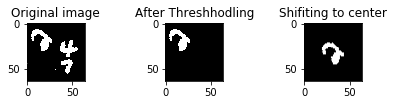

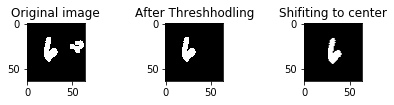

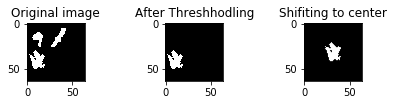

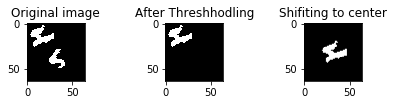

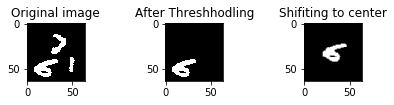

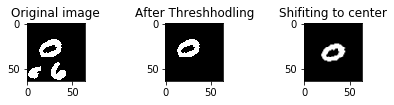

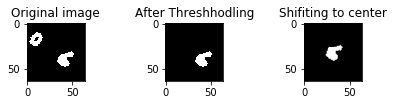

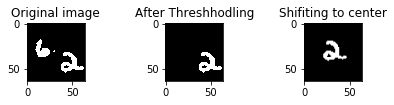

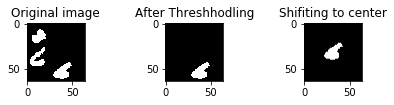

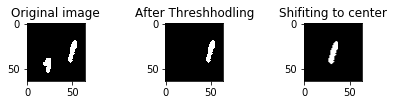

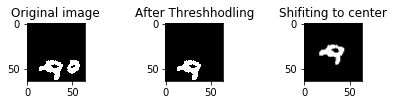

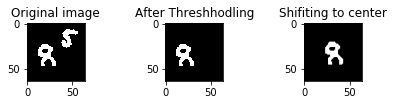

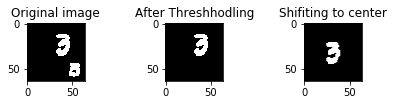

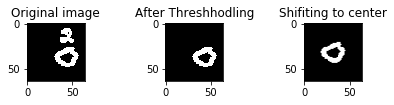

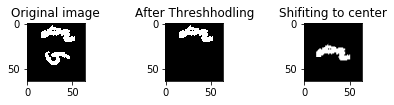

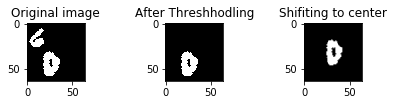

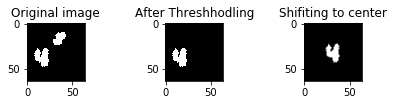

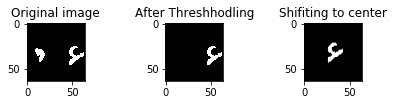

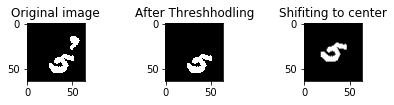

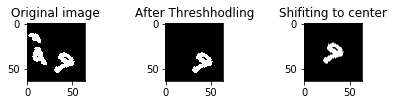

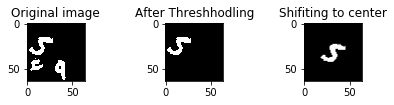

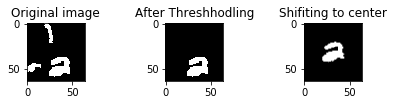

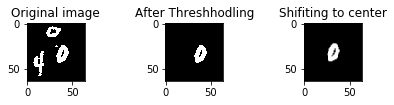

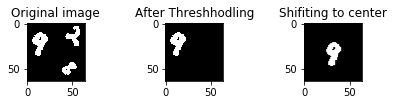

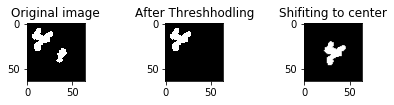

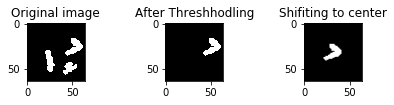

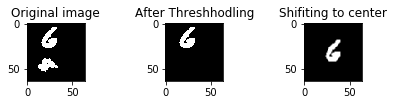

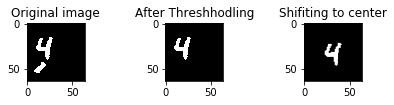

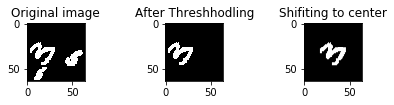

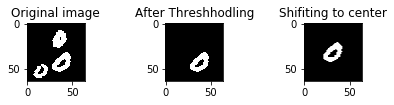

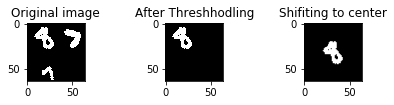

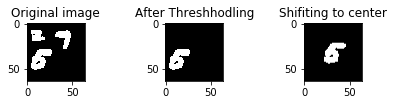

In [36]:
#for i in range(100):
#    plt.subplot(151)
#    plt.imshow(images[i], 'gray')
#    plt.title('Original image')
#    
#    plt.subplot(153)
#    plt.imshow(thresh_images[i], 'gray')
#    plt.title('After Threshhodling')
#    
#    plt.subplot(155)
#    plt.imshow(prepTrainX[i].reshape(64,64), 'gray')
#    plt.title('Shifiting to center')
#    plt.show()

# Write Solution

In [15]:
# takes a numpy 1-dimensional array and writes each value in a different row on the file
def write_solution(filename, y_pred):
    file = open(filename,"w")
    file.write("Id,Label" + "\n")
    for i in range(y_pred.shape[0]):
        file.write(repr(i) + "," + repr(int(y_pred[i])) + "\n")

In [16]:
def write_CV_optimal_params(filename, clf):
    file = open(filename,"w")
    file.write("Best Estimator:" + repr(clf.best_estimator_) + "\n") 
    file.write("Best Params:" + repr(clf.best_params_) + "\n")
    file.write("Best Score: " + repr(clf.best_score_) + "\n")
    file.write("The index of the split with the best score:" + repr(clf.best_index_) + "\n")
    file.write("Number of splits:" + repr(clf.n_splits_) + "\n")
    file.close()

# Normalization

In [17]:
# Normalize train set
from sklearn.preprocessing import normalize
normalize(prepTrainX, norm='l1', axis=1, copy=False, return_norm=False)

# Normalize test set
from sklearn.preprocessing import normalize
normalize(prepTestX, norm='l1', axis=1, copy=False, return_norm=False)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [37]:
print prepTrainX[:100,:100]

[[ 0.          0.          0.         ...,  0.00074193  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.00625978  0.00625978
   0.00625978]
 ..., 
 [ 0.          0.          0.         ...,  0.00337633  0.00387597
   0.00228622]
 [ 0.          0.          0.         ...,  0.00064674  0.00285598
   0.00369067]
 [ 0.          0.          0.         ...,  0.0007716   0.0007716
   0.0007716 ]]


# Results Before Preprocessing

In [25]:
X_train = X_train.reshape(50000, 4096)
X_test= X_test.reshape(10000,4096)

# SVM

In [ ]:
svc = svm.LinearSVC(penalty='l2', loss='squared_hinge')
parameters = {'C':[0.00001, 0.0001, 0.0001, 0.001, 0.1, 1, 10], 'random_state': [0]} #, 'kernel': ['linear','poly', 'rbf', 'sigmoid']
clf_svm = GridSearchCV(svc, parameters, n_jobs=4, refit=True)
y_pred = clf_svm.fit(X_train, y_train).predict(prepTestX)
write_solution('LinearSVM_Grid_Beforeprep.txt', y_pred)
print ("Best Estimator:", clf_svm.best_estimator_)
print ("Best Params:", clf_svm.best_params_)
print ("Best Score: ",clf_svm.best_score_)
print ("The index of the split with the best score:", clf_svm.best_index_)
print ("Number of splits:", clf_svm.n_splits_)

# Logistic Regression

In [ ]:
LogReg = linear_model.LogisticRegression(penalty='l2',random_state = 0)
parameters = {'C':[0.00001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]} 
clf_lr = GridSearchCV(LogReg, parameters, n_jobs=4, refit=True)
y_pred = clf_lr.fit(X_train, y_train).predict(prepTestX)
write_solution('Logistic-Regression_Grid_Beforeprep.txt', y_pred)
print ("Best Estimator:", clf_lr.best_estimator_)
print ("Best Params:", clf_lr.best_params_)
print ("Best Score: ",clf_lr.best_score_)
print ("The index of the split with the best score:", clf_lr.best_index_)
print ("Number of splits:", clf_lr.n_splits_)

# KNN

In [ ]:
KNN = neighbors.KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(5, 100, 10)}
clf_knn = GridSearchCV(KNN, parameters, n_jobs=4, refit=True)
y_pred = clf_knn.fit(X_train, y_train).predict(prepTestX)
write_solution('KNN_Grid_Beforeprep.txt', y_pred)
print ("Best Estimator:", clf_knn.best_estimator_)
print ("Best Params:", clf_knn.best_params_)
print ("Best Score: ",clf_knn.best_score_)
print ("The index of the split with the best score:", clf_knn.best_index_)
print ("Number of splits:", clf_knn.n_splits_)

# Results After Preprocessing

In [38]:
print(prepTrainX.shape)
print(prepTestX.shape)

(50000, 784)
(10000, 784)


In [ ]:
# free some memory from variables we will not need anymore
del X_train
del X_train_tmp
del X_test
del images_test
del images_train
del img1
del img2
del t_img
del thresh_images

# Linear SVM using GridSearchCV

In [32]:
svc = svm.LinearSVC(penalty='l2', loss='squared_hinge', random_state=0)
parameters = {'C':[0.00001, 0.0001, 0.0001, 0.001, 0.1, 1, 10]} 
clf_svm_prep = GridSearchCV(svc, parameters, n_jobs=4, refit=True)
y_pred = clf_svm_prep.fit(prepTrainX, y_train).predict(prepTestX)
write_solution('LinearSVM_Grid.txt', y_pred)
print ("Best Estimator:", clf_svm_prep.best_estimator_)
print ("Best Params:", clf_svm_prep.best_params_)
print ("Best Score: ",clf_svm_prep.best_score_)
print ("The index of the split with the best score:", clf_svm_prep.best_index_)
print ("Number of splits:", clf_svm_prep.n_splits_)

('Best Estimator:', LinearSVC(C=1e-05, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))
('Best Params:', {'C': 1e-05})
('Best Score: ', 0.61631999999999998)
('The index of the split with the best score:', 0)
('Number of splits:', 3)


Optimal CVGridSearch for LinearSVM:

('Best Estimator:', LinearSVC(C=1e-05, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))
('Best Params:', {'C': 1e-05})
('Best Score: ', 0.61631999999999998)
('The index of the split with the best score:', 0)
('Number of splits:', 3)

# Linear SVM after new preprocessing

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train1, y_valid = train_test_split(prepTrainX, y_train, test_size=0.1) #, random_state=0)


______________________________Support Vector Machine (SVM)______________________________



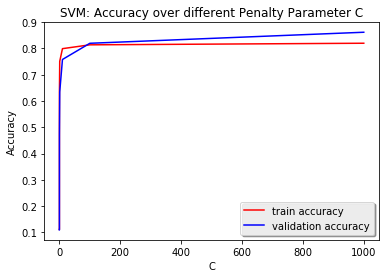


Train set__Maximum Accuracy = 0.8198 by C = 1000

Validation set__Maximum Accuracy = 0.8616 by C = 1000


In [25]:
print "\n______________________________Support Vector Machine (SVM)______________________________\n"
#Number of examples are greater than number of features --> Primal Problem 
acc_list_tr, acc_list_v = [], []
c_ = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
for c in c_:
    svc = LinearSVC(C=c, dual=False, penalty='l2', loss='squared_hinge', random_state=0)
    y_pred_train = svc.fit(x_train, y_train1).predict(x_train)
    y_pred_valid = svc.fit(x_valid, y_valid).predict(x_valid)
    a_tr = accuracy_score(y_train1, y_pred_train)
    a_v = accuracy_score(y_valid, y_pred_valid)
    acc_list_v.append(a_v)
    acc_list_tr.append(a_tr)
plt.plot(c_, acc_list_tr, color='r', label="train accuracy")
plt.plot(c_, acc_list_v, color='b', label="validation accuracy")
plt.legend(loc='best', shadow=True)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('SVM: Accuracy over different Penalty Parameter C')
plt.show()   
print "\nTrain set__Maximum Accuracy = {} by C = {}" .format(max(acc_list_tr),c_[acc_list_tr.index(max(acc_list_tr))])
print "\nValidation set__Maximum Accuracy = {} by C = {}" .format(max(acc_list_v),c_[acc_list_v.index(max(acc_list_v))])

# Linear SVM with GridSearch

In [34]:
svc = svm.LinearSVC(C=0.00001, penalty='l2', loss='squared_hinge', random_state=0)
parameters = {'C':[0.00001]} 
clf_svm_prep = GridSearchCV(svc, parameters, n_jobs=4, refit=True)
y_pred = clf_svm_prep.fit(prepTrainX, y_train).predict(prepTestX)
write_solution('LinearSVM_Grid_new.txt', y_pred)
print ("Best Estimator:", clf_svm_prep.best_estimator_)
print ("Best Params:", clf_svm_prep.best_params_)
print ("Best Score: ",clf_svm_prep.best_score_)
print ("The index of the split with the best score:", clf_svm_prep.best_index_)
print ("Number of splits:", clf_svm_prep.n_splits_)

('Best Estimator:', LinearSVC(C=1e-05, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))
('Best Params:', {'C': 1e-05})
('Best Score: ', 0.73336000000000001)
('The index of the split with the best score:', 0)
('Number of splits:', 3)


('Best Estimator:', LinearSVC(C=1e-05, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))
('Best Params:', {'C': 1e-05})
('Best Score: ', 0.73336000000000001)
('The index of the split with the best score:', 0)
('Number of splits:', 3)

# Kernalized SVM

In [ ]:
svc = svm.SVC(random_state= 0,kernel='rbf')
parameters = {'C':[0.00001]}
clf_svm_prep = GridSearchCV(svc, parameters, scoring='accuracy', n_jobs=4, refit=True, verbose=2)
y_pred = clf_svm_prep.fit(prepTrainX, y_train).predict(prepTestX)
write_solution('SVM_rbf_Grid.txt', y_pred)
print ("Best Estimator:", clf_svm_prep.best_estimator_)
print ("Best Params:", clf_svm_prep.best_params_)
print ("Best Score: ",clf_svm_prep.best_score_)
print ("The index of the split with the best score:", clf_svm_prep.best_index_)
print ("Number of splits:", clf_svm_prep.n_splits_)
write_CV_optimal_params('SVM_rbf_params.txt', clf_svm_prep)

In [ ]:
print "\n______________________________Kernelized SVM______________________________\n"
#Number of examples are greater than number of features --> Primal Problem 
acc_list_tr, acc_list_v = [], []
c_ = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
for c in c_:
    svc = svm.SVC(C=c, random_state= 0, kernel='poly')
    y_pred_train = svc.fit(x_train, y_train1).predict(x_train)
    y_pred_valid = svc.fit(x_valid, y_valid).predict(x_valid)
    a_tr = accuracy_score(y_train1, y_pred_train)
    a_v = accuracy_score(y_valid, y_pred_valid)
    acc_list_v.append(a_v)
    acc_list_tr.append(a_tr)
plt.plot(c_, acc_list_tr, color='r', label="train accuracy")
plt.plot(c_, acc_list_v, color='b', label="validation accuracy")
plt.legend(loc='best', shadow=True)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('SVM: Accuracy over different Penalty Parameter C')
plt.show()   
print "\nTrain set__Maximum Accuracy = {} by C = {}" .format(max(acc_list_tr),c_[acc_list_tr.index(max(acc_list_tr))])
print "\nValidation set__Maximum Accuracy = {} by C = {}" .format(max(acc_list_v),c_[acc_list_v.index(max(acc_list_v))])


______________________________Kernelized SVM______________________________



In [ ]:
svc = svm.SVC(random_state= 0,kernel='sigmoid')
parameters = {'C':[0.00001]}
clf_svm_prep = GridSearchCV(svc, parameters, scoring='accuracy', n_jobs=4, refit=True, verbose=2)
y_pred = clf_svm_prep.fit(prepTrainX, y_train).predict(prepTestX)
write_solution('SVM_sigmoid_Grid.txt', y_pred)
print ("Best Estimator:", clf_svm_prep.best_estimator_)
print ("Best Params:", clf_svm_prep.best_params_)
print ("Best Score: ",clf_svm_prep.best_score_)
print ("The index of the split with the best score:", clf_svm_prep.best_index_)
print ("Number of splits:", clf_svm_prep.n_splits_)
write_CV_optimal_params('SVM_sigmoid_params.txt', clf_svm_prep)

('Best Estimator:', SVC(C=1e-05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))
('Best Params:', {'kernel': 'sigmoid', 'C': 1e-05, 'random_state': 0})
('Best Score: ', 0.1114)
('The index of the split with the best score:', 0)
('Number of splits:', 3)


In [ ]:
svc = svm.SVC(random_state= 0,kernel='poly', degree = 9)
parameters = {'C':[0.00001]}
clf_svm_poly_prep = GridSearchCV(svc, parameters, scoring='accuracy', n_jobs=6, refit=True, verbose=2)
y_pred = clf_svm_poly_prep.fit(prepTrainX, y_train).predict(prepTestX)
write_solution('SVM_poly_Grid_Degree=9.txt', y_pred)
print ("Best Estimator:", clf_svm_poly_prep.best_estimator_)
print ("Best Params:", clf_svm_poly_prep.best_params_)
print ("Best Score: ",clf_svm_poly_prep.best_score_)
print ("The index of the split with the best score:", clf_svm_poly_prep.best_index_)
print ("Number of splits:", clf_svm_poly_prep.n_splits_)
write_CV_optimal_params('SVM_poly_params.txt', clf_svm_poly_prep)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................


Process PoolWorker-17:
Process PoolWorker-16:
Process PoolWorker-18:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mandana/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/mandana/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/mandana/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
    self.run()
  File "/home/mandana/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mandana/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/mandana/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/home/mandana/anaconda2/lib/python2.7/multiprocessing/pool.py"

Degree = 9 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=53.4min
[CV] .......................................... C=1e-05, total=53.3min
[CV] .......................................... C=1e-05, total=53.5min
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed: 87.5min finished
('Best Estimator:', SVC(C=1e-05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=9, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))
('Best Params:', {'C': 1e-05})
('Best Score: ', 0.75070000000000003)
('The index of the split with the best score:', 0)
('Number of splits:', 3)

Degree = 5 

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total= 6.0min
[CV] .......................................... C=1e-05, total= 6.0min
[CV] .......................................... C=1e-05, total= 6.0min
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed: 10.7min finished
('Best Estimator:', SVC(C=1e-05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))
('Best Params:', {'C': 1e-05})
('Best Score: ', 0.9173)
('The index of the split with the best score:', 0)
('Number of splits:', 3)


degree= 3

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total= 5.7min
[CV] .......................................... C=1e-05, total= 5.8min
[CV] .......................................... C=1e-05, total= 5.8min
[Parallel(n_jobs=6)]: Done   3 out of   3 | elapsed: 10.5min finished
('Best Estimator:', SVC(C=1e-05, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))
('Best Params:', {'C': 1e-05})
('Best Score: ', 0.91493999999999998)
('The index of the split with the best score:', 0)
('Number of splits:', 3)

# Logistic Regression using GridSearchCV

In [39]:
LogReg = linear_model.LogisticRegression(penalty='l2',random_state = 0)
parameters = {'C':[0.00001]} 
clf_lr_prep = GridSearchCV(LogReg, parameters, n_jobs=4, refit=True)
y_pred = clf_lr_prep.fit(prepTrainX, y_train).predict(prepTestX)
write_solution('Logistic-Regression_Grid.txt', y_pred)
print ("Best Estimator:", clf_lr_prep.best_estimator_)
print ("Best Params:", clf_lr_prep.best_params_)
print ("Best Score: ",clf_lr_prep.best_score_)
print ("The index of the split with the best score:", clf_lr_prep.best_index_)
print ("Number of splits:", clf_lr_prep.n_splits_)
write_CV_optimal_params('Log_Reg_CV_params.txt', clf_lr_prep)

('Best Estimator:', LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))
('Best Params:', {'C': 1e-05})
('Best Score: ', 0.74482000000000004)
('The index of the split with the best score:', 0)
('Number of splits:', 3)


In [ ]:
print "\n______________________________Logistic Regression______________________________\n"
#Number of examples are greater than number of features --> Primal Problem 
acc_list_tr, acc_list_v = [], []
c_ = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
for c in c_:
    LogReg = linear_model.LogisticRegression(C = c, penalty='l2',random_state = 0)
    y_pred_train = svc.fit(x_train, y_train1).predict(x_train)
    y_pred_valid = svc.fit(x_valid, y_valid).predict(x_valid)
    a_tr = accuracy_score(y_train1, y_pred_train)
    a_v = accuracy_score(y_valid, y_pred_valid)
    acc_list_v.append(a_v)
    acc_list_tr.append(a_tr)
plt.plot(c_, acc_list_tr, color='r', label="train accuracy")
plt.plot(c_, acc_list_v, color='b', label="validation accuracy")
plt.legend(loc='best', shadow=True)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('LR: Accuracy over different Penalty Parameter C')
plt.show()   
print "\nTrain set__Maximum Accuracy = {} by C = {}" .format(max(acc_list_tr),c_[acc_list_tr.index(max(acc_list_tr))])
print "\nValidation set__Maximum Accuracy = {} by C = {}" .format(max(acc_list_v),c_[acc_list_v.index(max(acc_list_v))])

('Best Estimator:', LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))
('Best Params:', {'C': 1e-05})
('Best Score: ', 0.74482000000000004)
('The index of the split with the best score:', 0)
('Number of splits:', 3)

'Best Estimator:', LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))
('Best Params:', {'C': 1e-05})
('Best Score: ', 0.62590000000000001)
('The index of the split with the best score:', 0)
('Number of splits:', 3)

# KNN using GridSearchCV

In [35]:
KNN = neighbors.KNeighborsClassifier()
parameters = {'n_neighbors':[15]}
clf_knn_prep = GridSearchCV(KNN, parameters, n_jobs=4, refit=True)
y_pred = clf_knn_prep.fit(prepTrainX, y_train).predict(prepTestX)
write_solution('KNN_Grid.txt', y_pred)
print ("Best Estimator: ",clf_knn_prep.best_estimator_)
print ("Best Params:", clf_knn_prep.best_params_)
print ("Best Score: ",clf_knn_prep.best_score_)
print ("The index of the split with the best score:", clf_knn_prep.best_index_)
print ("Number of splits:", clf_knn_prep.n_splits_)
write_CV_optimal_params('knn_CV_params.txt', clf_knn_prep)

('Best Estimator: ', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'))
('Best Params:', {'n_neighbors': 15})
('Best Score: ', 0.89168000000000003)
('The index of the split with the best score:', 0)
('Number of splits:', 3)


('Best Estimator: ', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'))
('Best Params:', {'n_neighbors': 15})
('Best Score: ', 0.89168000000000003)
('The index of the split with the best score:', 0)
('Number of splits:', 3)

# Random Forest 

('Best Estimator:', LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))
('Best Params:', {'C': 1e-05})
('Best Score: ', 0.62590000000000001)
('The index of the split with the best score:', 0)
('Number of splits:', 3)

In [38]:
Rf = RandomForestClassifier()

parameters = {'max_depth':np.arange(5, 100, 5), 
              'n_estimators':np.arange(5, 100, 10), 
              'max_features': np.arange(5, 100, 10)}

clf_rf_prep = GridSearchCV(Rf, parameters, n_jobs=4, refit=True)
y_pred = clf_rf_prep.fit(prepTrainX, y_train).predict(prepTestX)
write_solution('RF.txt', y_pred)
print ("Best Estimator: ",clf_rf_prep.best_estimator_)
print ("Best Params:", clf_rf_prep.best_params_)
print ("Best Score: ",clf_rf_prep.best_score_)
print ("The index of the split with the best score:", clf_rf_prep.best_index_)
print ("Number of splits:", clf_rf_prep.n_splits_)

('Best Estimator: ', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=75, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=95, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
('Best Params:', {'max_features': 75, 'n_estimators': 95, 'max_depth': 25})
('Best Score: ', 0.90461999999999998)
('The index of the split with the best score:', 0)
('Number of splits:', 3)


('Best Estimator: ', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=75, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=95, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
('Best Params:', {'max_features': 75, 'n_estimators': 95, 'max_depth': 25})
('Best Score: ', 0.90461999999999998)
('The index of the split with the best score:', 0)
('Number of splits:', 3)

('Best Estimator: ', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=75, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=95, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))
('Best Params:', {'max_features': 75, 'n_estimators': 95, 'max_depth': 25})
('Best Score: ', 0.78091999999999995)
('The index of the split with the best score:', 479)
('Number of splits:', 3)